# Assignment 01 - Pitfalls in Data Mining     
## CSCI E-108

The goal of data mining is to find important relationships in large complex datasets. These dataset typically contain a large number of variables. The **high-dimensional** nature of the data leads to some commonly encountered pitfalls which lead to incorrect inferences.   

In this assignment you will gain a bit of experience with three important concepts in data mining at a small scale. These methods are essential as the scale increases:  

1. **False Discovery Rate Control:** The goal of data mining is to find important relationships in large complex datasets. These dataset typically contain a large number of variables. The **high-dimensional** nature of the data leads to some commonly encountered pitfalls of incorrect inference, **false discovery**. A related problem is cutting off a large-scale analysis when a desired relationship is 'found'. This practice of **p-value mining** often leads to unwarranted inferences. You will apply false discovery rate (FDR) control methods to address this problem.   
2. **Key-Value Pairs:** Large scale data is typically managed using key-value (KV) pairs. The exercises in this assignment give you some experience working with KV pair data management.  
3. **Map and Reduce Processes:** Much of large scale data mining requires use of a split-apply-combine approach. The data is split into manageable chunks, analytic transformations are applied, and the result combined or aggregated. A commonly used class of a split-apply-combine algorithm is MapReduce. 

In order to keep the scope of this assignment manageable, you will use limited versions of KV pair management and MapReduce. Specifically, you will use common Python tools to implement these concepts rather than dedicated large scale analytic platforms. 

## Multiple Hypothesis Tesing

Testing multiple hypothesis in high-dimensional data is problematic. Exhaustively testing all pairwise relationships between variables in a data set is a commonly used, but generally misleading, from of **multiple comparisons**. The chance of finding false significance, using such a **data dredging** approach, can be surprisingly high. 

In this exercise you will perform multiple comparisons on **only 20 identically distributed independent (iid)** variables. Ideally, such tests should not find significant relationships, but the actual result is quite different. 

To get started, execute the code in the cell below to load the required packages. 

In [160]:
import pandas as pd
import numpy as np
import numpy.random as nr
from scipy.stats import ttest_ind, f_oneway
from itertools import product, combinations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb
import math
import time

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [161]:
import skimage
skimage.__version__

'0.24.0'

In this exercise you will apply a [t-test](https://www.statisticshowto.com/probability-and-statistics/t-test/) to all pairwise combinations of identical Normally distributed variables. In this case, we will create a data set with 20 iid Normal distributions of 1000 samples each. Execute the code in the cell below to find this data and display the mean and variance of each variable.  

In [162]:
ncolumns = 20
nr.seed(234)
normal_vars = nr.normal(size=(1000,ncolumns))
print('The means of the columns are\n', np.mean(normal_vars, axis = 0))
print('\nThe variances of the columns are\n', np.var(normal_vars, axis = 0))

The means of the columns are
 [-1.16191649e-01  2.80829317e-02 -1.78516419e-02 -1.44691489e-02
  3.03718152e-02  1.20007442e-02 -9.58845606e-05  1.98662580e-03
  4.94154934e-02 -4.11640866e-02 -6.32977862e-03 -5.93868192e-02
 -2.56373595e-02  1.43568791e-02 -1.44725765e-02 -1.37023955e-02
  1.80622439e-02  5.87029691e-02 -2.02650514e-02 -1.56346106e-02]

The variances of the columns are
 [0.94834508 1.04744241 1.0258018  0.96977571 1.0089001  1.04113864
 1.00657222 0.99192594 1.04713487 1.04329434 1.04023108 0.96791346
 1.03706907 1.07179865 1.01431404 1.05060289 1.02054329 0.9686211
 1.02810287 0.99521555]


Notice that means are close to 0.0 and variances are close to 1.0 respectively. As expected, there is not much difference between these variables.

How many of these t-tests will show **significance** at the 0.05 cut-off level? With 20 variables there are 190 unique pairwise combinations. We expect to find a number of falsely significant test results from this many pairwise tests. 

## Creating a hash 

The goal of this exercise is to compute pairwise hypothesis tests of the differences in means for each of the iid Normal vectors. Here you will compute the **key-value**, $[K,V]$, pairs. Each key must represent an index for the two vectors used to compute the test statistic. The keys will then be used to index the results of the hypothesis tests. 

The question is, how can we create a hash from the keys for the pair of vectors? In this case to we will use a simple, but far from optimal hash. For the two vector indicies $i, j$, for some key and modulo, $m$, we will compute the hash as:  

$$h(i,j) = \big(i + key*(j+1) \big) mod\ m$$

> **Exercise 1-1:** Given that our space of vectors is actually quite small, just 20, we do not need a sophisticated and scalable hash function. We take advantage of the fact that Pandas data frames use hash tables for index lookup. This hashed key is used to store and retrieve the values using the indicies of a Pandas data frame, in about $O(N)$ time.     

> In this exercise you will test a simple hash function and its inverse. Examine the code below and notice that the hash function encodes the two indexes into a single integer by simple additional and multiplication. The modulo operation limits the size of the hash table. However, to keep things simple you will not implement any hash collision resolution mechanism. As a result, the size of the table is set much larger than required.  

> To test this hash, do the following:    
> 1. Create a function called `hash_function` to compute the hash using the formula given above. The arguments to the function are $i$ and $j$, the $hash\_key$ and the $modulo$, the divisor for the modulo operator, $\%$. The number of buckets in the hash table is determined by the $modulo$ argument. The defaults of the arguments are $hash\_key=64$ and $modulo=1024$. The hash function, $h(i,j)$, is then:
> $$h(i,j) = \big(i + (j+1)*hash\_key \big)\ \%\ modulo$$
> Setting modulo much greater than number of the possible hashes, limits the probability of hash collisions. 
> 2. Complete the missing code in the `print_hashes` function.
>    -  Use the Python [ittertools.combinations](https://docs.python.org/3/library/itertools.html#itertools.combinations) function to create an itterator for all unique pairwise combinations of indexes i and j. The arguments to the combinaitons function are `range(ncolumns)` choose 2, since the comparisons are pairwise.
>    -  Within the loop call the hash_function with the values of $i$ and $j$ as arguments.
>    -  Append the hash computed to 'hash_list'   

In [163]:
modulo=1024
hash_key=64

def hash_function(i, j, hash_key, modulo):
    return (i + (j + 1) * hash_key) % modulo

import itertools

def print_hashes(hash_key, modulo=1024, print_hash=True):
    hash_list = []
    for i, j in itertools.combinations(range(ncolumns), 2):
        hash_value = hash_function(i, j, hash_key, modulo)
        hash_list.append(hash_value)
    return(hash_list)        
    
hash_list = print_hashes(hash_key=hash_key)  

> 3. The next question is how good is this hash function. We can run a simple test by plotting the hash values computed. Execute the code in the cell below to display a histogram and a cumulative distribution plot of the hash values. 

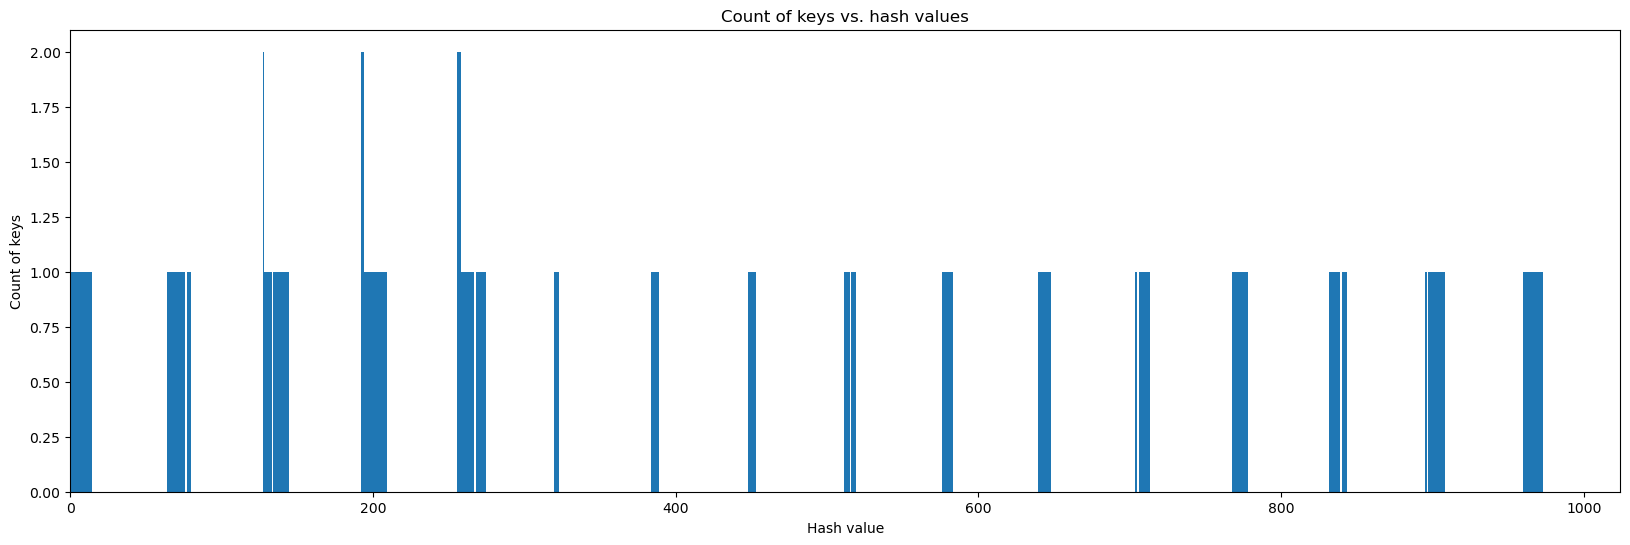

[1. 1. 1. ... 1. 1. 1.]


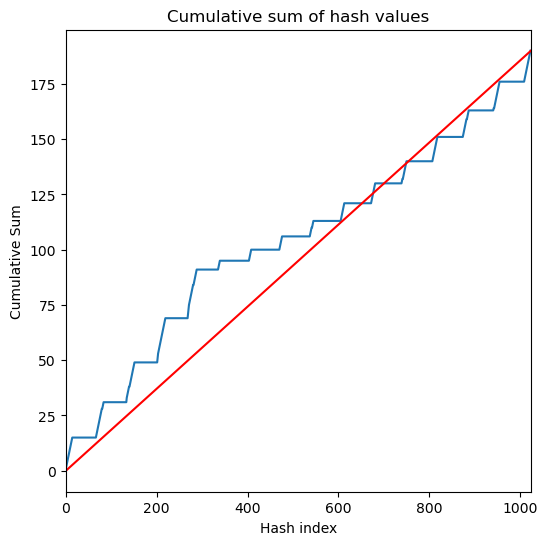

In [164]:
def plot_hash_keys(hashes, bins=1024, modulo=1024):
    fig, ax = plt.subplots(figsize=(20, 6))
    counts, bins, _ = ax.hist(hashes, bins=bins);
    ax.set_ylabel('Count of keys');
    ax.set_xlabel('Hash value');
    ax.set_title('Count of keys vs. hash values');
    ax.set_xlim(0.0, modulo)
    plt.show();
    print(counts)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(range(len(counts)), np.cumsum(counts))
    ax.plot([0.0,len(counts)], [0.0,len(hashes)], color='red');
    ax.set_ylabel('Cumulative Sum');
    ax.set_xlabel('Hash index');
    ax.set_title('Cumulative sum of hash values');
    ax.set_xlim(0.0, modulo)
    plt.show();
    
plot_hash_keys(hash_list)    

> This hash funciton is not ideal. One can see the deviation from a uniform disitribution of the hash key values.
>    - The hash key values are clustered, and not uniformly distributed.
>    - The cumulative distribution function deviates significantly from uniform. A hypothtical unifrom distribution would follow the red line.
>
> 4. The foregoing hash function used a binary key. Often using a prime number as a key gives a more uniform distribution of the hash values. To test this idea, execute the code in the cell below.    

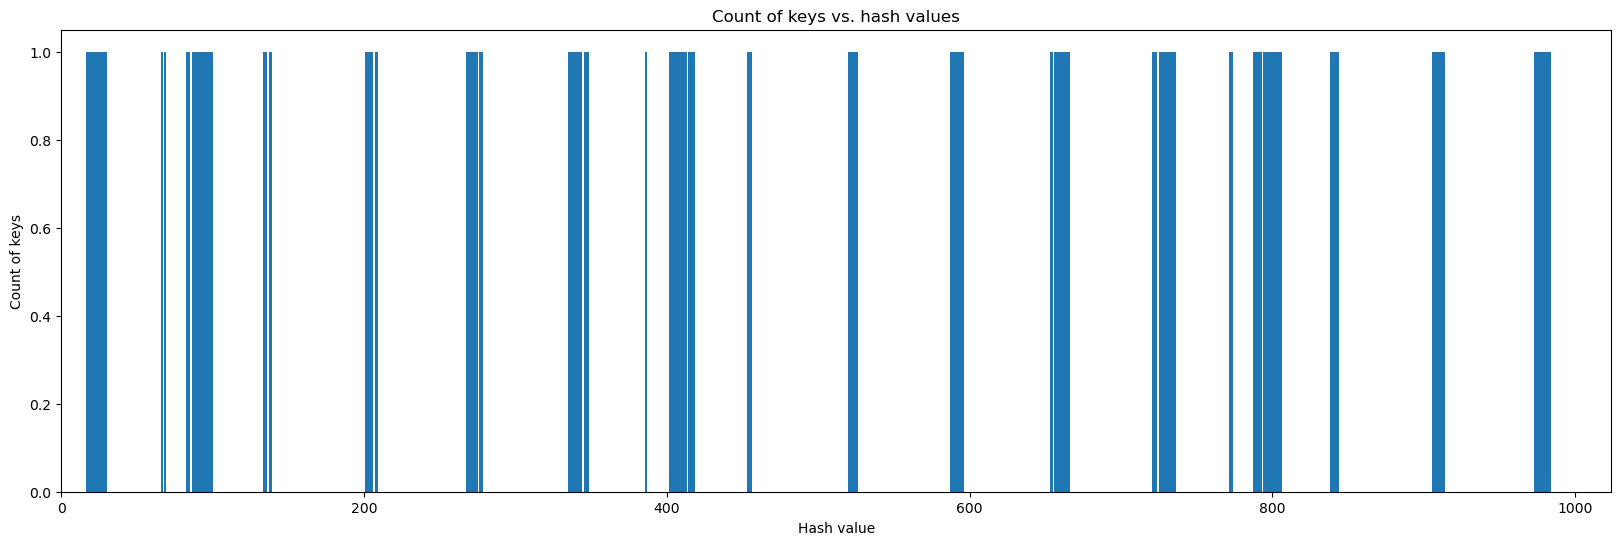

[1. 1. 1. ... 1. 1. 1.]


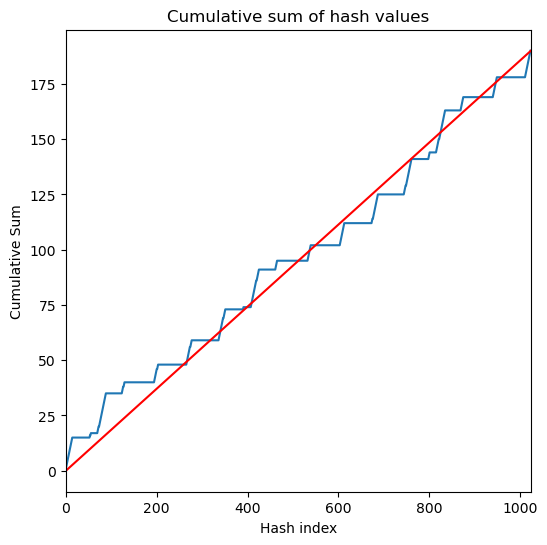

In [165]:
key=7873
hash_list = print_hashes(key,  print_hash=False)  
plot_hash_keys(hash_list)

> The histograms of the two hash functions look similar, but there is a noticable improvement in the cumulative distirbution plot using a prime number key.  
>
> The next question we should ask about this hash function with the prime number key is if there are any hash collisions. To find out, do the following.     
> 5. Print the length of the hash value list.  
> 6. Print the length of the unique hash values. You can find the unique values in a list with the [numpy.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) function. 

In [166]:
## Put your code below. 
unique_hashes = np.unique(hash_list)
print("Total hash values:", len(hash_list))
print("Unique hash values:", len(unique_hashes))

Total hash values: 190
Unique hash values: 190


> Examine the results you have Created and answer these questions.
> 1. An ideal hash function should not exhibit lumpiness or clustering of the hash values. Examine the histograms of the hash values generated with the prime number key. Do you see any evidence of lumpiness in the distribution of the hash values and what does this tell you about deviation from ideal behavior.  
> 2. Compare the cummulative distibution plots of the two hash functions. Which of these hash functions is closer to the uniform distribution and why?
> 3. What does your previous observation tell you about the choice of hash keys?   
> 4. Is there any evidence of hash key collisions and why?     
> **End of exercise.**

> **Answers:**
> 1. There is some lumpiness of hash values around certain numbers but no collisions at the same value (all at 1). This shows us that there is some deviation from ideal behavior, where the distribution would be perfectly uniform.      
> 2. The plot for the prime number key follows the red line (representing the ideal uniform distribution) more closely, so it is closer to the uniform distribution. 
> 3. It reveals that the prime number key provides a more uniform distribution of hash values, reducing clustering and improving the hash function's performance.
> 4. The length of the hash value list and the length of the unique hash values list are equal at 190, so there are no key collisions. The count values in the histogram also show this at 1 only for each hash value, so there is no evidence of collision.

## A MapReduce Example   

In the following steps you will use a simplified MapReduce framework to find and sort every possible pairwise t-test result for the `normal_vars` table. To do so you must find all **combinations** of keys, $\{i,j\}$. The MapReduce processes you will create, are intended to create a table of these unique pairwise key combinations. The t-test is then computed from the values in the `normal_vars` table in the Reduce process. This MapReduce process only creates the required key combinations. The values remain in the `normal_vars` table. This approach simplifies some of the bookkeeping.     

In a bit more details the steps for this algorithm are:   
- The **Map process** builds a hash table with the hash of i,j as key and i,j as values. As has been noted most of this hash table will contain NaNs. The hash table is still relatively small, since the values of the vectors used for the statistical calculations are not stored in the table, only the results. Please don't be confused by the switching roles of i,j as they act as keys and values at different times.   
- The **Shuffle** scans the hash table for non-empty rows (not NaN values for i,j) and builds a table of unique combination of keys i and j.   
- The **Reduce process** uses the keys i,j from the Shuffle process to look up the columns of the numeric random variables in the `normal_vars` table. The resulting table contains the i,j pairs as the keys for the random variable lookup. The t-test is applied to these numeric values. The results are sorted and returned.   

It is clear that at this small scale one could compute the t-test results for the combinations of the random variables directly. The point of the exercises is to get some experience working with key-value pairs and the MapReduce framework.  

### The map process

We are constructing this example a map and a reduce process. The processes are intended to compute the hypothesis test for differences of means between all the pairs of vectors. The first step is the map process, which creates the keys, or values of $i$ and $j$ for these pairs. This is an example of a **similarity join**.    

> **Computational Note:** In this exercise you will create your own simple hash table using a Pandas data frame. The data frame will be indexed by the key value computed by hashing the $[i,j]$ pairs, which gives nearly $O(n)$ performance for lookups. This implementation is only for demonstration purposes only and has several significant limitations compared to a production quality implementation. 
> 1. You will use a fixed length data frame. We take advantage of the fact the index lookup in Pandas data frames uses a hash table. In other words, referencing a row (or column) of a Pandas data frame is a key-value lookup using a hash table. 
> 2. You will not implement a collision resolution mechanism so a larger table is required, which is not particularly memory efficient. At scale, a sparse representation of the table would be used.     
> 3. You will not implement any table resizing mechanism. Again, a fixed size table is limited in the quantity of data the table can store and also results in poor memory utilization.  
> As an alternative, we could use the hashed $[K,V]$ pairs of a Python dictionary. However, a dictionary only allows one key value and we are working with 2, $\{i,j\}$. You could create a hash and then hash this hash with the built in function. In this case we will take the more direct route just described. If you are not familiar with Python dictionaries you can find a short tutorial [here](https://www.tutorialspoint.com/python_data_structure/python_hash_table.htm), as well as many other places on the web.   

> **Exercise 1-2:** You will now create the code for the map which build a data frame with $i, j$ key pairs indexed by the hash. By the following steps you will create code that represents a map task.  a
> 1. Create a data frame with two columns $i$ and $j$ with number of rows $= modulo$ and set all values to $= numpy.nan$.
> 2. Create a loop over all combinations of the pairs of i and j.   
> 2. Compute the hash value for the indexes, i and j.  
> 4. Add the $i$ and $j$ values to the row indexed by the hash value.  
> 5. Return the hash table.
> 6. Execute the function to create the hash table.
> 7. Compute and print the length of the hash table. 

In [167]:
def map_hypothesis(vars, hash_key, modulo):
    # Step 1: Create the DataFrame
    hash_table = pd.DataFrame(index=range(modulo), columns=['i', 'j'])
    hash_table[:] = np.nan
    
    # Step 2: Loop over combinations
    for i, j in itertools.combinations(range(vars.shape[1]), 2):
        # Step 3: Compute hash value
        hash_value = hash_function(i, j, hash_key, modulo)
        # Step 4: Add i and j to DataFrame
        hash_table.loc[hash_value] = [i, j]
    
    # Step 5: Return the hash table
    return hash_table, len(hash_table)

hash_key=7873
modulo = 1024
hash_table, nhashes = map_hypothesis(normal_vars, hash_key, modulo)
print('length of the table = ' + str(len(hash_table)))
hash_table.head()

length of the table = 1024


,i,j
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [168]:
normal_vars

array([[ 0.81879162, -1.04355064,  0.3509007 , ..., -0.17542066,
        -0.08270438, -0.88845473],
       [-0.30076649,  0.90837517, -0.64559131, ..., -0.46415036,
        -0.79785911,  1.31076281],
       [ 1.17479389, -0.05046953,  0.71895176, ...,  0.71999964,
        -0.86680023, -0.34668516],
       ...,
       [ 0.0943446 , -0.88593117,  2.21144516, ..., -0.48951209,
        -0.14650596,  1.468948  ],
       [-0.99396682, -0.60068401, -1.06598225, ...,  0.80637671,
        -0.38532756, -0.06067443],
       [-0.7191216 ,  0.0248463 ,  0.2728283 , ...,  0.3302862 ,
         0.2384886 ,  0.98507076]])

> **End of exercise.**

### The shuffle and reduce task

Now that you have the keys for the pairwise combinations of the vectors it is time to perform the reduce process. The reduce process computes the pair-wise t-statistics and p-values. These statistical values are indexed by the keys of the pair of vectors. This process reduces the full vectors of values down to just two numbers for each pair of vectors. 

> **Exercise 1-3:** You will now create and apply the following code for the reduce process:   
> 1. Create an empty data frame, called  `test_results`, with columns, `i`, `j`, `t_statistic`, and `p_value`, and length of the previously created hash table.    
> 2. Iterate over the combinations of possible $\{i,j \}$ values.  
> 3. For the $i,j$ pairs index the values in the random variable vectors of the `normal_vars` data frame and use them to compute the pair-wise t-statistic and p-value with the [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) function.
> 4. Assign the values to the row in the data frame indexed by the hash value of $\{i,j \}$. Use the `hash_function` previously created. Index the data frame using the Pandas `loc` method.     
> 5. Return the data frame, sorted in ascending order, using the [Pandas.DataFrame.sort_values](https://turned.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html).    
> 6. Execute your function and save the returned data frame.   
> 7. Display the first 10 rows of the data frame.  

In [169]:
def reduce_significance(hash_table, values, hash_key, modulo):
    
    # Step 1: Create the DataFrame
    test_results = pd.DataFrame(index=range(modulo), columns=['i', 'j', 't_statistic', 'p_value'])

    # Step 2: Loop over combinations
    for i, j in itertools.combinations(range(values.shape[1]), 2):
        # Step 3: Compute t-statistic and p-value
        t_stat, p_val = ttest_ind(values[:, i], values[:, j])
        
        # Step 4: Store results in DataFrame
        hash_value = hash_function(i, j, hash_key, modulo)
        test_results.loc[hash_value] = [i, j, t_stat, p_val]
    
    # Step 5: Return the sorted DataFrame
    return test_results.sort_values('p_value', axis=0, ascending=True)  
        
test_stats = reduce_significance(hash_table, normal_vars, hash_key, modulo)       
test_stats.head(10)

,i,j,t_statistic,p_value
402,0,17,-3.992565,0.000068
201,0,8,-3.705426,0.000217
453,0,4,-3.311203,0.000946
386,0,1,-3.227865,0.001267
721,0,16,-3.02412,0.002525
654,0,13,-2.903111,0.003735
134,0,5,-2.872598,0.004114
413,11,17,-2.682146,0.007375
520,0,7,-2.68157,0.007388
839,0,6,-2.62443,0.008746


> 9. In the cell below, create a filter for the pair-wise test cases which are significant and save these cases in a new data frame. 
> 10. Print the number (len) of significant results.
> 11. Print the rows with the significant test results.

In [170]:
significance_level = 0.05
## Put your code below. 

# Filter significant test cases
significant_results = test_stats[test_stats['p_value'] < significance_level]

# Print the number of significant results
print(f"Number of significant results: {len(significant_results)}")

# Print the rows with significant test results
print(significant_results)


Number of significant results: 22
      i   j t_statistic   p_value
402   0  17   -3.992565  0.000068
201   0   8   -3.705426  0.000217
453   0   4   -3.311203  0.000946
386   0   1   -3.227865  0.001267
721   0  16    -3.02412  0.002525
654   0  13   -2.903111  0.003735
134   0   5   -2.872598  0.004114
413  11  17   -2.682146  0.007375
520   0   7    -2.68157  0.007388
839   0   6    -2.62443  0.008746
587   0  10     -2.4624  0.013885
276   8  11     2.42258  0.015499
772   0   3   -2.321463  0.020362
335   0  14   -2.294894  0.021842
16    0  15   -2.291186  0.022056
788   0  19   -2.279797  0.022725
411   9  17   -2.225359  0.026168
67    0   2   -2.212194  0.027066
83    0  18   -2.156647  0.031152
973   0  12   -2.031263   0.04236
272   4  11    2.017791  0.043747
914   8   9    1.980137  0.047825


> Notice the large number of apparently 'significant' test results. Answer the following questions:  
> 1. Is the number of false positive cases approximately what you expected given that the vectors are iid Normal random variables?    
> 2. Examine which of the iid Normal vectors contribute to the false positive results. Are there vectors which contribute multiple times?   
> **End of exercise.**

>  **Answers:**   
> 1. There are more false positives than expected. We should expect 190 pairs * 5% = around 9.5 pairs positive. We have instead observed 22, but deviation is expected with different random samples.  
> 2. Yes, vectors contribute multiple times, such as i=0, j=17, j=11, etc.    

### Bonferroni correction  

Several adjustments to the multiple comparisons problem have been proposed. Dunn published a method know as the **Bonferroni correction** in 1961. The Bonferroni correction is a widely used method to reduce the false positive rate of hypothesis tests.  The adjustment is simple:
$$\alpha_b = \frac{\alpha}{m}\\
with\\ 
m =\ number\ of\ groups$$

Can the Bonferroni correction help? Yes, by greatly increasing the confidence level required for a statistically significant result. The problem with the Bonferroni correction is the reduction in power as the  grows smaller. For big data problems with large numbers of groups, this issue can be especially serious. In fact, the Bonferroni correction can often lead to significant numbers of missed discoveries, or Type II errors. 

> **Exercise 1-4:** You will now apply the Bonferroni correction to determining the significance of the p-values of the pair-wise t-tests. Do the following:
> 1. Compute the Bonferroni significance level. 
> 2. Apply this cutoff to the p-values of all of the cases.
> 3. Print the number of false discoveries, or Type I errors. 
> Execute your code and examine the results

In [171]:
# Compute the Bonferroni significance level
significance_bonferroni = significance_level/190.0

# Filter test cases based on the Bonferroni significance level
significant_tests = test_stats[test_stats.iloc[:,3] < significance_bonferroni]

# Print the number of false discoveries (Type I errors)
print(f"Number of false discoveries (Type I errors) after Bonferroni correction: {len(significant_tests)}")

Number of false discoveries (Type I errors) after Bonferroni correction: 2


> Does using the  Bonferroni correction reduce false significance tests, or even eliminate them?           

> **Answer:**  Yes, using the Bonferroni correction significantly reduced false positives by applying a lower p value threshold.         

> But, can we detect small effect with Bonferroni correction, as this method significantly reduces power of tests? Execute the code in the cell below, which compares a standard Normal to a Normal with a small mean (effect size), to find out. 

In [172]:
nr.seed(567)
print(significance_bonferroni)
print(ttest_ind(normal_vars[:,0], nr.normal(loc = 0.01, size=1000)))

0.0002631578947368421
TtestResult(statistic=-2.4955348814664315, pvalue=0.012656841327097476, df=1998.0)


> Provide a short answer to these questions:        
> 1. Given the Bonferroni correction and this difference in means, would this result be considered significant or would it be a type II error, and why?    
> 2. What does this result tell you about the downside of the Bonferroni correction as a FDR control method, in terms of finding significant results?      
> **End of exercise.**

> **Answers:**      
> 1. If we are using the Bonferroni correction p value threshold, then the resulting p-value is not significant and the small difference in mean between the datasets is not captured.  
> 2. The downside of Bonferroni correction is that it sacrifices precision, being conservative, increasing the number of false negatives while reducing false positives.    

## Improved False Discovery Rate Control Methods 

We have seen the potential pitfalls of multiple hypothesis testing. Further, we have seen that a simple approach to **false discovery rate (FDR) control** is not effective. You will now apply more sophisticated FDR control methods. 

The specific problem we will explore is to determine which genes lead to expression of a certain disease. In this example, there are gene expression data for 97 patients. Some of these patients have ulcerative colitis, a condition believed not to be inheritable, and others have Crohn's disease, which is believed to be genetically inherited.    

One approach to this problem is to perform hypothesis tests on the expression of the genes between patients with the two conditions. Since there are over 10,000 genes there is considerable chance for false discovery. Therefore, careful application of FDR control is required.

To continue with the example, execute the code in the cell below to load the data and print the dimensionality of the data frame. 

In [173]:
gene_data = pd.read_csv('ColonDiseaseGeneData-Cleaned.csv')
print(gene_data.shape)

(97, 10498)


There are data from 97 patients (rows) with 10,497 genes (features in columns). A large number of pairwise hypothesis tests are required!     

Execute the code in the cell below to view the first 5 columns of the data frame, which includes the expression of the first 4 genes.  

In [174]:
 print(gene_data.iloc[:,:5])      

              Disease State  FAM138F  LOC100133331  LOC100132062  LOC388312
0   Ulcerative Colitis (UC)   7.2980        8.5650        8.7778     9.2365
1   Ulcerative Colitis (UC)   8.0751        8.3536        8.7785     9.4256
2   Ulcerative Colitis (UC)   6.8458        8.8254        9.1960     9.8835
3   Ulcerative Colitis (UC)   7.6507        8.1838        8.2845     8.8011
4   Ulcerative Colitis (UC)   7.3524        8.4415        8.6630     9.1292
5   Ulcerative Colitis (UC)   7.2811        8.4023        8.6892     9.3487
6   Ulcerative Colitis (UC)   7.8913        8.8026        8.6892     8.4706
7   Ulcerative Colitis (UC)   7.0641        8.5498        8.7145     9.0538
8   Ulcerative Colitis (UC)   7.5266        8.8004        9.1334     9.8241
9   Ulcerative Colitis (UC)   7.0322        8.8119        9.1838     9.8496
10  Ulcerative Colitis (UC)   7.0657        8.6229        8.9592     9.5281
11  Ulcerative Colitis (UC)   7.5924        8.5463        9.1006     9.7927
12  Ulcerati

You will apply two FDR control methods to these data to reduce the FDR rate, and compare the results to the Bonferroni method. These methods control the FDR, while not being overly conservative on true positive results, like the Bonferronic correction. 

### Holm's method

The first of these **Holm's method**. Holm's method operates on the ordered set of p-values, $D = \{ p_{(1)}, p_{(2)}, p_{(3)}, \ldots, p_{(n)} \}$. The threshold is dynamic with the order of the P-value. For the $ith$ p-value, $p(i)$ for $N$ pairwise tests is:  

$$p(i) \le Threshold(Holm's) = \frac{\alpha}{N - i + 1}$$

For example: for the 10th ordered p-value with 1,000 total tests (genes) and significance level of 0.05, the cutoff is:   

$$p(10) \le \frac{0.05}{1000 - 10 + 1} = 0.00005045$$

### Map process  

> **Exercise 01-5:** To start the processing of these data you will first create and execute code for a map process. The map process groups the data by the patient's disease into 2 data frames, `ulcerative`, and `crohns`. The keys for each of these key-value pairs are the gene identifier. Notice that one key is all that is needed in this case. Now do the following to create and execute a function, `map_gene` to do the following:   
> 1. Create a logical mask and group the values by `Disease State`.
> 2. Use the mask to divide the original data frame into two data frames, one for ulcerative colitis and one for Crohns diseasse.
> 3. Return the transpose of the two data frames, removing the `Disease State` column. The result of this operation should be data frames with gene expressions for each patient in the columns and the gene identifier as the row index. 
> 4. Print the heads of the two data frames.  

In [175]:
def map_gene(gene_data):  
    ## Your code goes below 
    ## First, separate the columns by disease type  
    mask = gene_data.loc[:,'Disease State'] == 'Ulcerative Colitis (UC)'
    ulcerative = gene_data[mask]
    crohns = gene_data[np.logical_not(mask)]
    return ulcerative.iloc[:,1:].transpose(), crohns.iloc[:,1:].transpose()
    
ulcerative, crohns = map_gene(gene_data) 

> 3. Execute the code in the two cells below to display the heads of these data frames and examine the results. 

In [176]:
ulcerative.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
FAM138F,7.2980,8.0751,6.8458,7.6507,7.3524,7.2811,7.8913,7.0641,7.5266,7.0322,7.0657,7.5924,7.0600,7.1898,7.2143,7.0964,7.2198,7.3403,7.4461,7.3455,7.0880,7.2825,7.1724,6.8806
LOC100133331,8.5650,8.3536,8.8254,8.1838,8.4415,8.4023,8.8026,8.5498,8.8004,8.8119,8.6229,8.5463,8.7177,8.9140,8.5502,8.7591,9.2102,9.4456,8.5284,8.6927,8.2631,8.7345,8.3719,8.5305
LOC100132062,8.7778,8.7785,9.1960,8.2845,8.6630,8.6892,8.6892,8.7145,9.1334,9.1838,8.9592,9.1006,9.0183,9.4450,8.8953,9.2912,9.7642,10.0189,8.7357,9.0602,8.4369,9.1484,8.7555,8.8483
LOC388312,9.2365,9.4256,9.8835,8.8011,9.1292,9.3487,8.4706,9.0538,9.8241,9.8496,9.5281,9.7927,9.6008,10.1850,9.5342,9.9657,10.5014,10.7591,9.2506,9.7192,8.8794,9.7872,9.4038,9.3340
BC016143,7.3570,7.4431,7.5415,7.7199,7.4482,7.4577,8.6198,7.9258,7.4278,7.8487,7.3141,7.3871,7.5602,7.3844,7.2356,8.1990,7.4642,7.4081,7.7304,7.5309,7.9830,7.9588,7.5957,7.4893


In [177]:
crohns.head()

,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96
FAM138F,7.2068,7.8298,7.2091,7.0550,7.1302,7.5896,7.1414,7.5786,7.3579,7.2707,8.0351,7.5432,7.1810,7.5264,7.3716,7.4850,7.4165,6.9773,7.8786,7.5083,7.0880,6.8838,6.8119,7.2496,6.8267,7.0636,7.6835,7.2210,6.8487,7.5918,7.1678,7.3017,7.1610,7.2261,7.1593,7.1019,7.3116,7.8494,7.2701,7.5647,7.2515,7.1507,7.4678,7.5946,7.4190,7.1283,7.1075,7.5319,7.4337,6.8102,6.7455,7.4960,7.2845,7.0643,7.3322,7.2334,7.1355,7.3307,7.3263,7.5301,7.2411,7.7174,7.8088,6.8142,7.0029,7.1317,7.2842,7.0717,7.3420,6.6286,6.7240,7.5894,7.4378
LOC100133331,8.7216,8.9175,8.9301,8.5439,8.4071,8.6109,8.5179,8.5027,8.4111,8.4076,8.0996,8.3209,8.2516,8.7270,8.4931,8.3430,8.2109,8.3712,8.1959,8.5155,8.4385,8.4538,8.3748,8.9122,8.9778,9.4644,9.3493,8.7814,8.8734,8.2312,8.1288,9.2388,9.7806,9.3428,9.3831,8.3430,8.4065,8.3663,8.4757,8.8474,8.6235,8.8505,8.3267,8.6988,8.4272,8.6103,8.6806,8.8390,8.1981,8.4159,8.4007,9.1633,8.9434,8.2883,8.6903,8.4386,8.1473,8.6789,8.6000,8.5545,8.5200,8.6790,8.7493,9.1015,8.8982,8.5958,8.9521,8.7461,8.3204,9.7240,9.5739,9.7265,8.8964
LOC100132062,8.9883,9.1842,9.2968,8.8213,8.6142,8.8517,8.7155,8.6525,8.6590,8.8388,8.1967,8.6573,8.4162,9.0187,8.7526,8.5856,8.3940,8.7869,8.5050,8.7980,8.8253,8.7470,8.5175,9.4422,9.3882,10.0785,9.8959,9.1714,9.2340,8.5544,8.3662,9.7731,10.4121,9.8967,9.8278,8.5420,8.4365,8.7258,8.8142,9.1067,8.8586,9.3616,8.4853,9.0260,8.7151,9.0461,9.0847,9.2998,8.4922,8.7216,8.6120,9.4830,9.1429,8.6007,9.0542,8.6074,8.4648,9.1033,8.7555,8.6041,8.9117,8.9892,8.9242,9.6005,9.1675,8.9374,9.2933,9.1679,8.5116,10.2898,10.2080,10.3238,9.3807
LOC388312,9.4779,9.6337,9.8979,9.4340,9.0457,9.3895,9.1508,8.9109,9.1606,9.4837,8.6139,9.2815,8.9155,9.5883,9.2896,9.1303,8.8056,9.4372,9.0982,9.3524,9.4505,9.2828,8.9693,10.1554,10.0778,10.8549,10.6338,9.8162,9.8769,9.1008,8.9679,10.5605,11.2396,10.6759,10.5998,8.9747,8.6799,9.3271,9.3429,9.6523,9.3837,10.0741,8.8199,9.5730,9.3093,9.6250,9.6714,9.9908,9.0470,9.2068,9.0240,10.0791,9.6071,9.1311,9.6266,9.0808,9.0846,9.6172,9.1330,8.8550,9.4735,9.5009,9.2937,10.3573,9.7203,9.6554,9.8822,9.7870,8.9684,11.1171,11.0556,11.1514,10.1370
BC016143,8.0481,8.1224,7.8660,7.4640,7.7226,7.4770,7.7176,8.1704,7.8795,7.4256,7.6490,7.5086,7.3649,7.5547,7.4353,7.2359,7.6896,7.3325,7.5772,8.0188,7.7060,7.5093,7.4226,7.3826,7.4499,7.6519,7.3737,7.5800,7.5518,7.6202,7.3509,7.6288,7.8099,7.5718,7.6041,7.6090,8.1176,7.5379,7.8327,7.5541,7.8376,7.9190,7.8672,7.5682,7.4784,7.8521,7.6496,7.3517,7.4401,7.6754,7.8093,8.0799,7.8189,7.9144,7.9798,7.6367,7.5875,7.3403,7.6071,7.7039,7.9817,7.8251,8.0923,7.8580,8.2655,7.4652,7.6534,8.0463,7.7518,7.6910,7.8168,7.7033,7.4519


### Reduce process 

> **Exercise 01-6:** With the key-value pairs organized by disease state, it is time to create and execute code of a reduce process. The reduce process will compute the pairwise t-statistics and p-values for each gene and return the sorted results. Specifically, your `gene_test` with arguments of the two mapped data frames will do the following:   
> 1. Create an empty results data frame with using the hash key (gene identifier) as an index and columns t_statistics, and p-value.
> 2. Use a `for` loop to iterate over the keys of either data frame.  
> 3. Compute the t-statistic and p-value for the gene (key) for the pairwise tests between the data frames.
> 4. Assign the values to the row in the data frame using the gene identifier as index with the Pandas `loc` method.    
> 5. Sort the results data frame, `inplace`, into ascending order.
> 6. Return the resulting data frame.
> 7. Call the function and print the first 10 rows of the data frame.  

In [178]:
def gene_test(ulcerative, crohns):  
    test_results = test_results = pd.DataFrame(index = ulcerative.index, columns=['t_statistic','p_value'])
    ## Put your code below. 

    for gene in ulcerative.index:
        t_stat, p_val = ttest_ind(ulcerative.loc[gene], crohns.loc[gene])
        test_results.loc[gene] = [t_stat, p_val]

    test_results.sort_values(by='p_value', inplace=True)
    
    return test_results
    
gene_statistics = gene_test(ulcerative, crohns)    
gene_statistics.head(10)

,t_statistic,p_value
CPQ,-6.868466,0.0
FOSB,6.356964,0.0
GBA3,-6.162788,0.0
LMNA,5.98175,0.0
DMKN,5.881375,0.0
NT5DC3,5.857816,0.0
EPB41L3,-5.761396,0.0
NR1H4,-5.74931,0.0
LOC284454,5.68883,0.0
NR4A2,5.664503,0.0


### Significance of results 

With the gene data reduced to the t-test statistics, you will now determine the significance of these tests. It is important to understand that scientists believe that expression of a disease, like Corhn's, is only in a small number of genes, less than approximately 100.  

> **Exercise 01-6:** As a first step in understanding the gene expression significance complete and execute the code in the cell below to find the number of 'significant' genes using the simple single hypothesis test cutoff criteria.  

In [179]:
significance_level =0.05

# Count the number of significant genes
significant_genes = gene_statistics[gene_statistics['p_value'] < significance_level]
num_significant_genes = len(significant_genes)

print("Number of statistically significant genes:", num_significant_genes)


Number of statistically significant genes: 2548


> Does this large number of 'statistically significant' results appear credible, given that only a few genes are thought to have significant expression for this disease and why in terms of FDR?    
> **End of exercise.**     

> **Answer:**     It does not appear credible since around 25% seem to be significant. In terms of FDR, there are a large amount of false positives due to the sheer amount of data being assessed and pairwise tests being done. Differences in means of gene expression alone also cannot verify one disease or the other (shouldn't we have a third control group, and also separate data into test and training sets to see if the gene expression is significant on unused data?)

> **Exercise 01-7:** We have already seen that the Bonferroni correction is a rather conservative approach to testing the significance of large numbers of hypotheses. You will now use the Bonferroni correction to test the significance of the gene expression, by completing the code in the cell below. In this case, the number of pairwise tests is the number of rows in the `gene_statistics` table. 

In [180]:
# Number of tests performed (number of genes)
num_tests = len(gene_statistics)

# Bonferroni corrected significance level
bonferroni_significance_level = significance_level / num_tests

# Count the number of significant genes based on Bonferroni correction
significant_genes_bonferroni = gene_statistics[gene_statistics['p_value'] < bonferroni_significance_level]
num_significant_genes_bonferroni = len(significant_genes_bonferroni)

print("Number of statistically significant genes (Bonferroni correction):", num_significant_genes_bonferroni)


Number of statistically significant genes (Bonferroni correction): 59


> Does the foregoing result seems reasonable in terms of discovery rate and FDR control?    
> **End of exercise.**   

> **Answer:**   The result seems reasonable in terms of discovery rate (expected < 100 genes in instructions) , but in terms of FDR, perhaps too conservative as there were 10497 tests done so we are getting 0.5% significant instead of 5%. There may be false negatives.   

> **Exercise 01-08:** It may well be the case that the foregoing results using the Bonferroni correction is too conservative. You will now apply the Holms method to determining significance of the gene expression test results. In the cell below complete the `holms_significance` function with arguments of the results data frame and the significance level. This function does the following:  
> 1. Find the number of test results and compute the denominator used for the cutoff calculation. 
> 2. Compute the vector of thresholds using the Holms formula. Use the Python `range`function to get the values of the index i. But, keep in mind that range produces a zero-indexed iterator, and the algorithm needs a one-indexed list.  Use the [numpy.divide](https://numpy.org/doc/stable/reference/generated/numpy.divide.html) function to perform the vector divide. Save these threshold values in a data frame in a 'holms_threshold' column.   
> 3. Using the threshold values compute a logical vector and save it in a logical type column named 'significant' in the data frame.
> 4. Return the data frame.
> Finally, execute the function and save the results in a data frame. Then find and print the length of the subset where the 'significance' value is True. 

In [181]:
def holms_significance(test_results, significance):
    ## First compute the thresholds for each of the ordered tests
    ## Put your code below. 
   
    # Number of tests
    num_tests = len(test_results)
    
    # Compute the dynamic thresholds using Holm's method formula
    thresholds = significance / (num_tests - np.arange(1, num_tests) + 1)
    
    # Save the threshold values in a data frame
    test_results['holms_threshold'] = np.concatenate((thresholds, [np.nan]))
    
    # Compute a logical vector for significance
    test_results['significant'] = test_results['p_value'] <= test_results['holms_threshold']
    
    return test_results

holms_results = holms_significance(gene_statistics, significance_level)    
len(holms_results.loc[holms_results.loc[:,'significant'],:])

59

> Consider the differences between the calculation of the Bonferroni correction and Holm's threshold. Do you expect any practical difference in the number of significant tests given ordering by the p-value index, $i$? What is the meaning of the similarity or difference of the actual results in this case?  
> **End of exercise.**

> **Answer:**  The result is both 59 significant genes in this case. For large number of tests, index i is negligible compared to large N and so the calculation of Bonferroni and Holm's yields the same threshold as the denominators is approximately the same.    

You can visualize the results of the Holm's method test. The plot has two key elements:  
1. Plot the curve of the p-values vs. the order number, i. The line is color coded by significance or not.
2. Plot the threshold line. This line is straight since the threshold is a linear function of i.

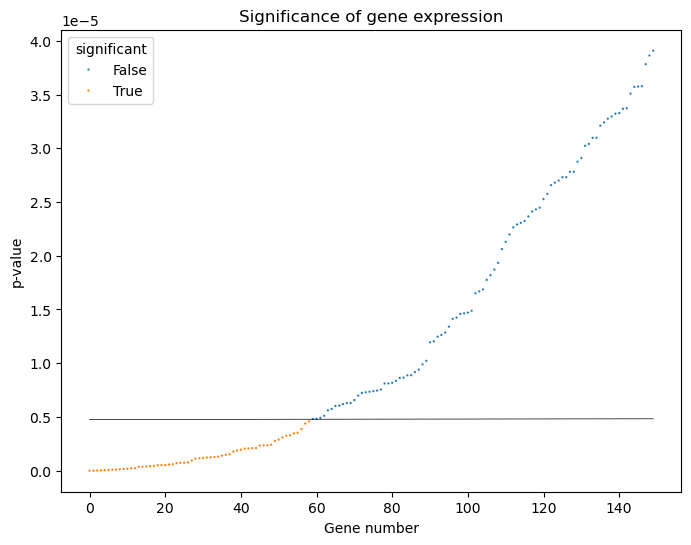

In [182]:
def plot_significance(results, threshold):
    results['number'] = range(len(results))
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(x='number',y=threshold, data=results, ax=ax, color='black', linewidth=0.5)
    sns.scatterplot(x='number',y='p_value', hue='significant', data=results, s=3, ax=ax)
    ax.set_title('Significance of gene expression')
    ax.set_xlabel('Gene number')
    ax.set_ylabel('p-value')
    
plot_significance(holms_results.iloc[:150,:].copy(), 'holms_threshold')    

Notice the following about this plot:  
1. The p-value significance line crosses the threshold point at an apparent break point.   
2. The significant p-values are all very small since there are so many tests.
3. The Holm's threshold is does not change very much over the first 150 test results. 

### Benjamini-Hochberg FDR Control 

The Benjamini-Hochberg FDR control algorithm is another way to control false discoveries. Stat with an ordered set of $n$ p-values, $D = \{ p_{(1)}, p_{(2)}, p_{(3)}, \ldots, p_{(n)} \}$ we define a false discovery rate, $q$:

$$FDR(D) \le q$$

The cutoff threshold for the ith p-value is then:
$$p_{(i)} \le Threshold(D_q) = \frac{q}{n} i$$

> **Exercise 01-9:** In this exercise you will apply the Benjamini-Hochberg FDR control algorithm for testing the significance of the gene expressions. The `BH_significance` function is quite similar to the Holm's method function you have already created. Given the large number of genes you must use a low false discovery rate, $q = 0.001$, or 1 out of 1,000. 
> Execute your function, saving the result. Then print the number of significant cases. 

In [183]:
def BH_significance(test_results, false_discovery_tollerance):
    ## First compute the thresholds for each of the ordered tests
    ## Put your code below. 
   
    # Number of tests
    num_tests = len(test_results)
    
    # Compute the Benjamini-Hochberg thresholds
    thresholds = false_discovery_tollerance * np.arange(1, num_tests + 1) / num_tests
    
    # Save the threshold values in a data frame
    test_results['bh_threshold'] = thresholds
    
    # Compute a logical vector for significance
    test_results['significant'] = test_results['p_value'] <= test_results['bh_threshold']
    
    return test_results

BH_results = BH_significance(gene_statistics, 0.001)    
len(BH_results.loc[BH_results.loc[:,'significant'],:])

71

> This result differs from the first two FDR control methods you have applied. Given the false discovery parameter of 0.001 do you think this is a reasonable result and why? 

> **Answer:**  This is reasonable as the false discovery parameter of 0.001 is slightly higher than the Bonferroni and Holm cutoff threshold (or lowest end of ordered p(i)s in the case of Holm), so we expect more significant gene results in this case.    

Finally, execute the code in the cell below and examine the resulting plot.

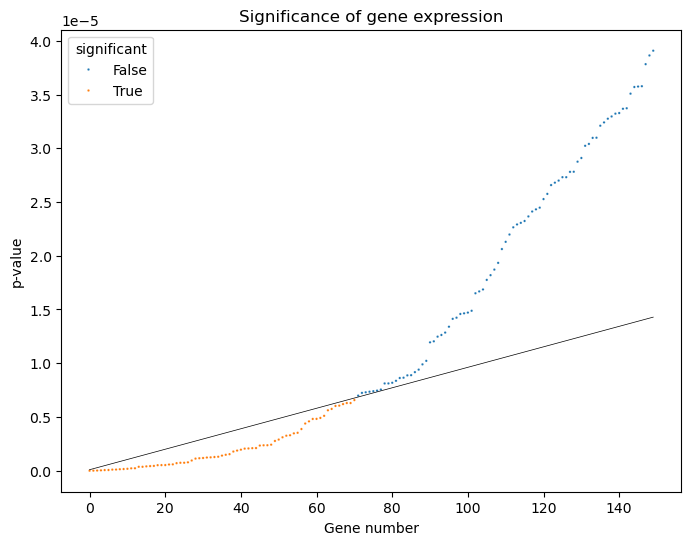

In [184]:
plot_significance(BH_results.iloc[:150,:].copy(), 'bh_threshold')    

> **Exercise 01-10**: Compare the plots of results of the Benjamini-Hochberg FDR control method to those of Holm's method. Why does the Benjamini-Hochberg FDR control method give a more dynamic or adaptive result for the case where $i << n$? 

> **Answer:**   This is because the cutoff scales with i independent of how small i is relative to n in the Benamini-Hochberg FDR case as i is multiplied instead of subtracted off from N in the case of Holm.

##### Copyright 2021, 2022, 2023, 2024 Stephen F. Elston. All rights reserved. 